# Cross Country Performance Analysis

This notebook analyzes cross country running performance data, including:
- Gender distribution
- Performance trends over time
- Geographic distribution of meets
- Performance normalization and adjustment for course conditions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as sch
import plotly.express as px
import plotly.graph_objects as go
import os

## Data Loading and Preprocessing

In [2]:
def load_data():
    """Load all CSV files from the data directory."""
    directory_path = '../data/nrcd/data'
    
    # Load each CSV file into a pandas DataFrame
    team_df = pd.read_csv(os.path.join(directory_path, 'team.csv'))
    athlete_df = pd.read_csv(os.path.join(directory_path, 'athlete.csv'))
    sport_df = pd.read_csv(os.path.join(directory_path, 'sport.csv'))
    running_event_df = pd.read_csv(os.path.join(directory_path, 'running_event.csv'))
    meet_df = pd.read_csv(os.path.join(directory_path, 'meet.csv'))
    result_df = pd.read_csv(os.path.join(directory_path, 'result.csv'))
    course_details_df = pd.read_csv(os.path.join(directory_path, 'course_details.csv'))
    athlete_team_association_df = pd.read_csv(os.path.join(directory_path, 'athlete_team_association.csv'))
    
    # Convert date columns to datetime
    meet_df['start_date'] = pd.to_datetime(meet_df['start_date'], format='%Y-%m-%d', errors='coerce')
    meet_df['end_date'] = pd.to_datetime(meet_df['end_date'], format='%Y-%m-%d', errors='coerce')
    
    return (team_df, athlete_df, sport_df, running_event_df, meet_df, 
            result_df, course_details_df, athlete_team_association_df)

# Load the data
team_df, athlete_df, sport_df, running_event_df, meet_df, result_df, course_details_df, athlete_team_association_df = load_data()

/var/folders/gg/slmc0tvs2sb21yvlp_ln94dh0000gn/T/ipykernel_31864/3576222513.py:11: DtypeWarning: Columns (5,7,9,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  result_df = pd.read_csv(os.path.join(directory_path, 'result.csv'))


## Data Merging and Initial Analysis

In [3]:
def merge_dataframes(athlete_df, result_df, meet_df):
    """Merge the dataframes for analysis."""
    # Merge athlete and result data
    athlete_result_df = pd.merge(athlete_df, result_df, on='athlete_id')
    
    # Merge the result with meet data
    full_df = pd.merge(athlete_result_df, meet_df, on='meet_id')
    
    return full_df

# Merge dataframes
full_df = merge_dataframes(athlete_df, result_df, meet_df)

# Analyze gender distribution
gender_counts = athlete_df['gender'].value_counts()
print(f"Number of men: {gender_counts.get('M', 0)}")
print(f"Number of women: {gender_counts.get('F', 0)}")

Number of men: 16127
Number of women: 10209


## Cross Country Performance Analysis

In [4]:
def analyze_cross_country_performance(sport_df, meet_df, result_df, athlete_df, running_event_df):
    """Analyze cross country performance data."""
    # Get cross country sport ID
    cross_country_sport_id = sport_df[sport_df['sport_name'].str.contains('Cross Country', case=False, na=False)]['sport_id'].values[0]
    
    # Define date range
    start_date = datetime(2024, 8, 1)
    end_date = datetime(2025, 5, 1)
    
    # Filter meets by date range and sport
    cross_country_meets = meet_df[
        (meet_df['sport_id'] == cross_country_sport_id) &
        (meet_df['start_date'] >= start_date) &
        (meet_df['start_date'] <= end_date)
    ]
    
    # Filter results for cross country meets
    cross_country_results = result_df[result_df['meet_id'].isin(cross_country_meets['meet_id'])]
    
    # Merge with athlete data
    cross_country_athletes = pd.merge(cross_country_results, athlete_df, on='athlete_id')
    
    # Merge with running event data to get event names
    cross_country_athletes = pd.merge(cross_country_athletes, running_event_df[['running_event_id', 'event_name']], 
                                    on='running_event_id', how='left')
    
    # Merge with meet data to get start_date
    cross_country_athletes = pd.merge(cross_country_athletes, cross_country_meets[['meet_id', 'start_date']], 
                                    on='meet_id', how='left')
    
    return cross_country_athletes

# Analyze cross country performance
cross_country_athletes = analyze_cross_country_performance(sport_df, meet_df, result_df, athlete_df, running_event_df)

## Time Processing and Normalization

In [5]:
def parse_time(time_str):
    """Convert time string to seconds."""
    parts = time_str.split(":")
    if len(parts) == 3:
        hours, minutes, seconds = map(float, parts)
        return hours * 3600 + minutes * 60 + seconds
    elif len(parts) == 2:
        minutes, seconds = map(float, parts)
        return minutes * 60 + seconds
    else:
        return float(time_str)

def format_parsed_time(seconds):
    """Convert seconds to formatted time string."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    if hours > 0:
        return f"{hours}:{minutes:02d}:{seconds:05.2f}"
    elif minutes > 0:
        return f"{minutes}:{seconds:05.2f}"
    else:
        return f"{seconds:05.2f}"

def adjust_time_for_race(event_name, time, course_details, gender):
    """Adjust race time based on course details and conditions."""
    event_dist = None
    if event_name.endswith('m'):
        event_dist = float(event_name.replace('m', '').strip())
    elif event_name.endswith('mi'):
        event_dist = float(event_name.replace('mi', '').strip()) * 1609.34
    
    hill_slow_time = 0
    hill_speed_time = 0
    
    if event_dist:
        if pd.notna(course_details.get('elevation_gain')) or pd.notna(course_details.get('elevation_loss')):
            if pd.notna(course_details.get('elevation_gain')):
                grade_increase_percentage = course_details['elevation_gain'] / event_dist * 100
                hill_slow_time = time * 0.04 * grade_increase_percentage
            if pd.notna(course_details.get('elevation_loss')):
                grade_decrease_percentage = course_details['elevation_loss'] / event_dist * 100
                hill_speed_time = time * 0.0267 * grade_decrease_percentage
            time += hill_speed_time - hill_slow_time

        if pd.notna(course_details.get('estimated_course_distance')):
            factor = event_dist / course_details['estimated_course_distance']
            if gender == 'F':
                time *= factor ** 1.055
            elif gender == 'M':
                time *= factor ** 1.08

    if pd.notna(course_details.get('temperature')) and pd.notna(course_details.get('dew_point')):
        weather_factor = course_details['temperature'] + course_details['dew_point']
        if weather_factor > 100:
            percent_increase = 0.0015 * (weather_factor - 100) ** 2
            time *= 1 - (percent_increase / 100)

    return time

def normalize_and_adjust_time(row):
    """Normalize and adjust time for a given row of data."""
    parsed_time = parse_time(row['result_time'])
    
    if pd.notna(row.get('course_details_id')):
        course_details = {
            'elevation_gain': row.get('elevation_gain'),
            'elevation_loss': row.get('elevation_loss'),
            'estimated_course_distance': row.get('estimated_course_distance'),
            'temperature': row.get('temperature'),
            'dew_point': row.get('dew_point')
        }
        adjusted_time = adjust_time_for_race(row['event_name'], parsed_time, course_details, row['gender'])
    else:
        adjusted_time = parsed_time

    event_dist = None
    if row['event_name'].endswith('m'):
        event_dist = float(row['event_name'].replace('m', '').strip())
    elif row['event_name'].endswith('mi'):
        event_dist = float(row['event_name'].replace('mi', '').strip()) * 1609.34

    if event_dist:
        if row['gender'] == 'F':
            normalized_time = adjusted_time * (6000 / event_dist)**1.08
        elif row['gender'] == 'M':
            normalized_time = adjusted_time * (8000 / event_dist)**1.055
        else:
            normalized_time = adjusted_time
    else:
        normalized_time = adjusted_time
        
    return format_parsed_time(normalized_time)

# Process and normalize times
cross_country_athletes['final_adjusted_time'] = cross_country_athletes.apply(normalize_and_adjust_time, axis=1)
cross_country_athletes['final_parsed_adjusted_time'] = cross_country_athletes['final_adjusted_time'].apply(parse_time)

## Performance Visualization

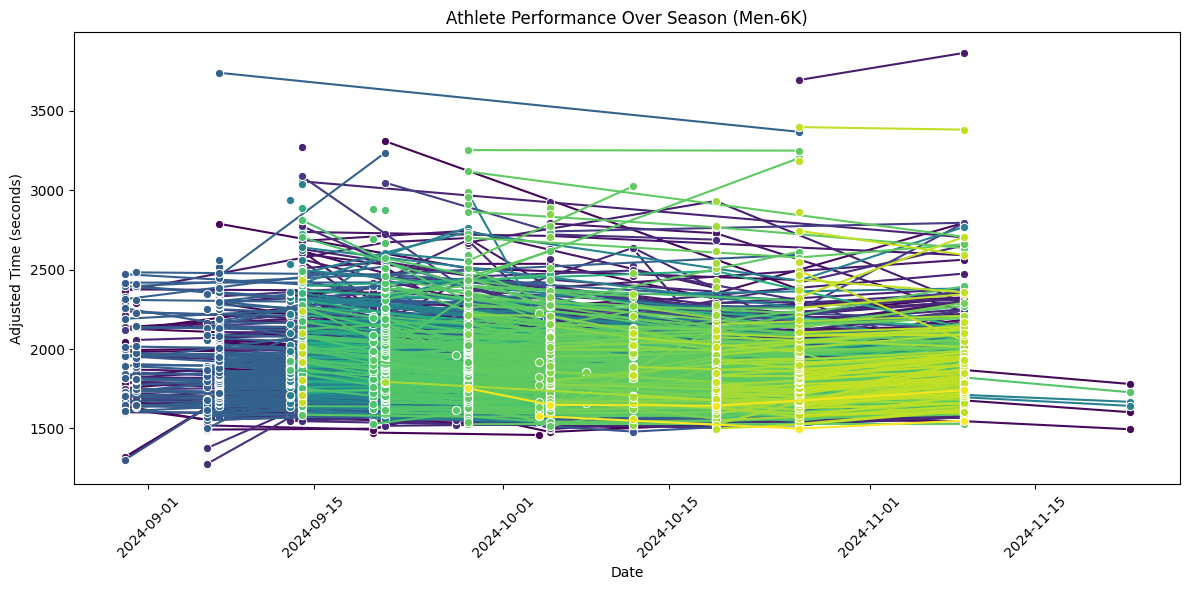

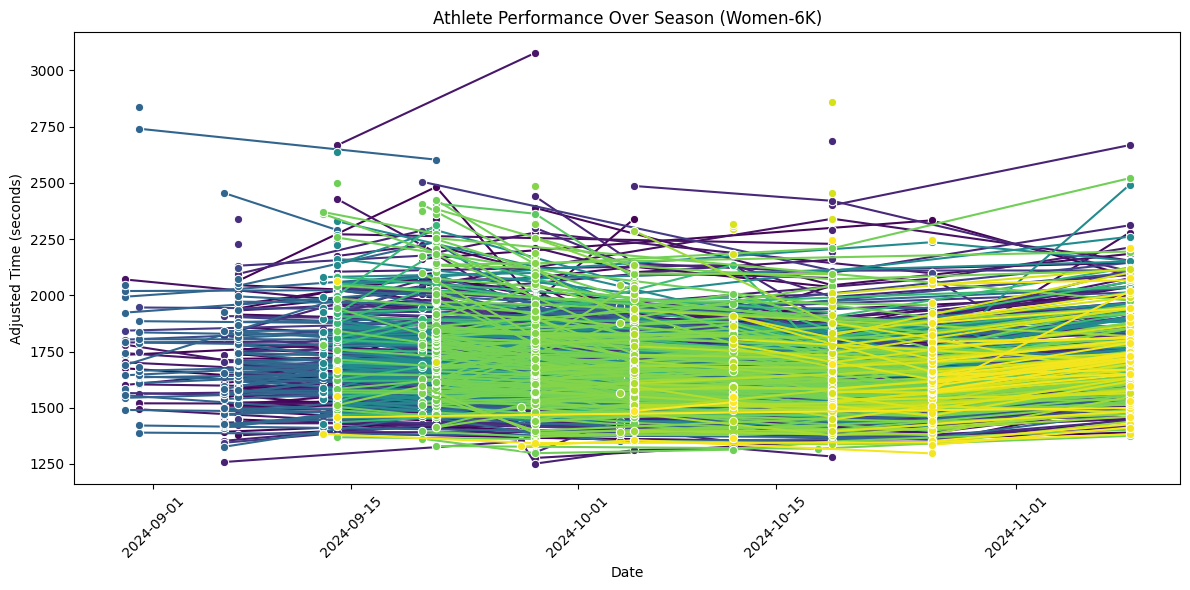

In [6]:
def plot_performance_over_time(data, gender):
    """Plot performance over time for a specific gender."""
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data, x='start_date', y='final_parsed_adjusted_time', 
                hue='athlete_id', marker='o', palette='viridis', legend=None)
    plt.title(f'Athlete Performance Over Season ({gender}-{"8K" if gender == "M" else "6K"})')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Separate male and female athletes
male_athletes = cross_country_athletes[cross_country_athletes['gender'] == 'M']
female_athletes = cross_country_athletes[cross_country_athletes['gender'] == 'F']

# Plot performance over time
plot_performance_over_time(male_athletes, 'Men')
plot_performance_over_time(female_athletes, 'Women')

## Improvement Rate Analysis

In [7]:
def calculate_improvement_rate(data):
    """Calculate improvement rate using linear regression."""
    slopes = []
    for athlete_id in data['athlete_id'].unique():
        athlete_df = data[data['athlete_id'] == athlete_id].sort_values('start_date')
        if len(athlete_df) > 1:
            X = np.array(athlete_df['start_date'].map(pd.Timestamp.toordinal)).reshape(-1, 1)
            y = athlete_df['final_parsed_adjusted_time'].values
            
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]
            slopes.append(slope)
    
    return np.mean(slopes)

# Calculate improvement rates
male_improvement = calculate_improvement_rate(male_athletes)
female_improvement = calculate_improvement_rate(female_athletes)

print(f"Average Improvement Rate (Men): {male_improvement:.2f} seconds per day")
print(f"Average Improvement Rate (Women): {female_improvement:.2f} seconds per day")

Average Improvement Rate (Men): -0.58 seconds per day
Average Improvement Rate (Women): -0.12 seconds per day


## State Name Normalization for Geographic Analysis

In [8]:
# Map full state names and abbreviations to abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}
# Create a new dictionary with reverse mappings
state_abbreviations_with_reverse = state_abbreviations.copy()
for abbr in state_abbreviations.values():
    state_abbreviations_with_reverse[abbr] = abbr

def normalize_state(state):
    return state_abbreviations_with_reverse.get(str(state).strip(), str(state).strip())

meet_df['normalized_state'] = meet_df['meet_state'].apply(normalize_state)


## Geographic Distribution Analysis

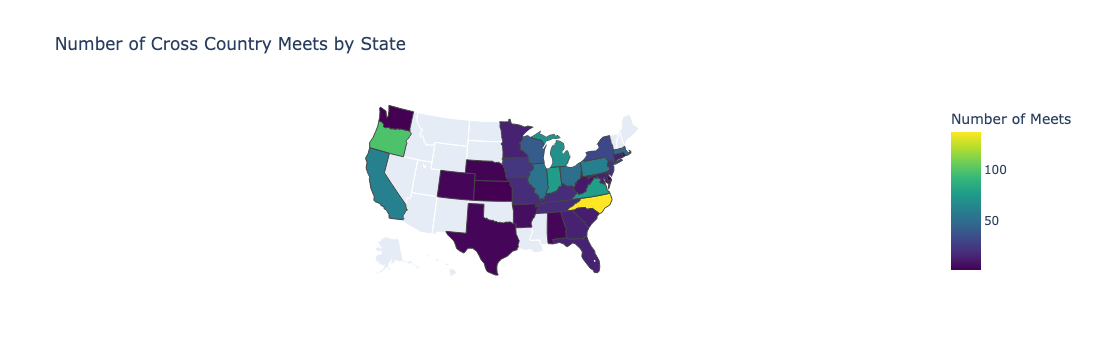

In [9]:
def create_state_choropleth(meet_df):
    """Create a choropleth map of meets by state."""
    results_by_state = meet_df['normalized_state'].value_counts().to_dict()
    state_data = pd.DataFrame(list(results_by_state.items()),
                            columns=['State', 'Results'])
    fig = go.Figure(data=go.Choropleth(
        locations=state_data['State'],
        z=state_data['Results'],
        locationmode='USA-states',
        colorscale='Viridis',
        colorbar_title="Number of Meets",
    ))
    fig.update_layout(
        title_text='Number of Cross Country Meets by State',
        geo=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
        ),
    )
    fig.show()

# Create state choropleth
create_state_choropleth(meet_df)